# Big data lab

## import library

In [57]:
import pandas as pd
import pickle
import my_func
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fe_name_tr = 'churn_train_model_fe.pickle'
b_num_name_tr ='churn_train_model_b_num.pickle'
dpi_name_tr ='churn_train_model_dpi.pickle'

fe_name_te = 'churn_test_model_fe.pickle'
b_num_name_te ='churn_test_model_b_num.pickle'
dpi_name_te ='churn_test_model_dpi.pickle'

file_path = r'D:\BDL-Final\data-from-BDL' + '\\'

# settings for dataframe
pd.set_option('display.max_columns', None)

In [78]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'n_estimators': 100,
    'early_stopping_rounds': 20,
    'is_unbalance': True,
    'random_state': 42
}


In [58]:
# Load dataframes
df_train_fe = pd.read_pickle(file_path+fe_name_tr)
df_train_dpi = pd.read_pickle(file_path+dpi_name_tr)
df_train_b_num = pd.read_pickle(file_path+b_num_name_tr)

df_test_fe = pd.read_pickle(file_path+fe_name_te)
df_test_dpi = pd.read_pickle(file_path+dpi_name_te)
df_test_b_num = pd.read_pickle(file_path+b_num_name_te)



In [81]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

def binary_classification_metrics(y_true_tr, y_pred_tr, y_true_val=None, y_pred_val=None, report=False):
    print("{:<15} {:<10} {:<10} {:<10}".format('Metrics', 'Train', 'Test', '\u0394'))
    metrics_dict = {}

    metrics_dict['roc_auc'] = np.round(roc_auc_score(y_true_tr, y_pred_tr), 4)
    metrics_dict['accuracy'] = np.round(accuracy_score(y_true_tr, y_pred_tr), 4)
    metrics_dict['precision'] = np.round(precision_score(y_true_tr, y_pred_tr), 4)
    metrics_dict['recall'] = np.round(recall_score(y_true_tr, y_pred_tr), 4)
    metrics_dict['f1_score'] = np.round(f1_score(y_true_tr, y_pred_tr), 4)

    if y_true_val is not None:
        metrics_dict_test = {}
        metrics_dict_test['roc_auc'] = np.round(roc_auc_score(y_true_val, y_pred_val), 4)
        metrics_dict_test['accuracy'] = np.round(accuracy_score(y_true_val, y_pred_val), 4)
        metrics_dict_test['precision'] = np.round(precision_score(y_true_val, y_pred_val), 4)
        metrics_dict_test['recall'] = np.round(recall_score(y_true_val, y_pred_val), 4)
        metrics_dict_test['f1_score'] = np.round(f1_score(y_true_val, y_pred_val), 4)
        
        for metrics, value in metrics_dict.items():
            value_test = metrics_dict_test[metrics]
            diff = np.round(metrics_dict_test[metrics] - value, 4)
            print("{:<15} {:<10} {:<10} {:<10}".format(metrics, value, value_test, diff))
    else:
        for metrics, value in metrics_dict.items():
            print("{:<15} {:<10}".format(metrics, value))
    
    if report:
        print('\n')
        print('Train:')
        print(classification_report(y_true_tr, y_pred_tr))
        if y_true_val is not None:
            print('Test:')
            print(classification_report(y_true_val, y_pred_val))


# Prepare your data (X and y)
X = df_train_fe.drop(['target', 'abon_id'], axis=1)
y = df_train_fe['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on train and test sets
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Evaluate the model
binary_classification_metrics(y_train, y_train_pred, y_test, y_test_pred, report=True)


Metrics         Train      Test       Δ         
roc_auc         0.8913     0.8215     -0.0698   
accuracy        0.8749     0.8597     -0.0152   
precision       0.3276     0.2831     -0.0445   
recall          0.9101     0.7776     -0.1325   
f1_score        0.4818     0.4151     -0.0667   


Train:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    112334
         1.0       0.33      0.91      0.48      7666

    accuracy                           0.87    120000
   macro avg       0.66      0.89      0.71    120000
weighted avg       0.95      0.87      0.90    120000

Test:
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     28080
         1.0       0.28      0.78      0.42      1920

    accuracy                           0.86     30000
   macro avg       0.63      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000



In [70]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(y_train, y_train_pred, y_test, y_test_pred, title):
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    plt.plot(fpr_train, tpr_train, color='blue', label="Train, AUC={:.3f}".format(auc_train), linestyle='-')
    plt.plot(fpr_test, tpr_test, color='black', label="Test, AUC={:.3f}".format(auc_test), linestyle='--')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(title, fontweight='bold', fontsize=15)
    plt.legend(prop={'size': 13}, loc='lower right')

    plt.show()


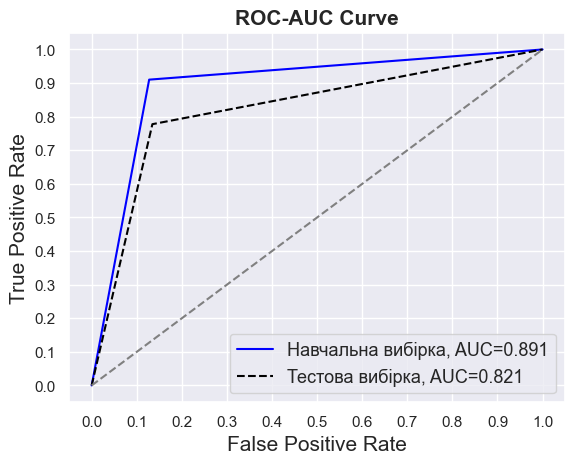

In [75]:
plot_roc_auc(y_train, y_train_pred, y_test, y_test_pred, "ROC-AUC Curve")


In [73]:
#saving model
save_model(clf, X.columns.tolist()) 


Save LGBMClassifier_24062023_13_31.pickle


## Classification Metrics

In [60]:

def binary_classification_metrics(y_true_tr, y_pred_tr, y_true_val = None, y_pred_val = None, report = False):
    print ("{:<15} {:<10} {:<10} {:<10}".format('Metrics','Train','Test','\u0394'))
    metrics_dict = {}

    metrics_dict['roc_auc'] = np.round(roc_auc_score(y_true_tr, y_pred_tr),4)
    metrics_dict['accuracy'] = np.round(accuracy_score(y_true_tr, y_pred_tr),4)
    metrics_dict['precision'] = np.round(precision_score(y_true_tr, y_pred_tr),4)
    metrics_dict['recall'] = np.round(recall_score(y_true_tr, y_pred_tr),4)
    metrics_dict['f1_score'] = np.round(f1_score(y_true_tr, y_pred_tr),4)
    
    if y_true_val is not None:
        metrics_dict_test = {}
        metrics_dict_test['roc_auc'] = np.round(roc_auc_score(y_true_val, y_pred_val),4)
        metrics_dict_test['accuracy'] = np.round(accuracy_score(y_true_val, y_pred_val),4)
        metrics_dict_test['precision'] = np.round(precision_score(y_true_val, y_pred_val),4)
        metrics_dict_test['recall'] = np.round(recall_score(y_true_val, y_pred_val),4)
        metrics_dict_test['f1_score'] = np.round(f1_score(y_true_val, y_pred_val),4)
        # print(classification_report(y_true_val, y_pred_val))
    
        for metrics, value in metrics_dict.items():
            value_test = metrics_dict_test[metrics]
            diff = np.round(metrics_dict_test[metrics] - value, 4)
            print ("{:<15} {:<10} {:<10} {:<10}".format(metrics, value, value_test, diff))
    else:
        for metrics, value in metrics_dict.items():
            print ("{:<15} {:<10}".format(metrics, value))
    if report:
        print('\n')
        print('Train :')
        print(classification_report(y_true_tr, y_pred_tr))
        if not y_true_val.empty:
            print('Test :')
            print(classification_report(y_true_val, y_pred_val))

## First look

# Feature Engineering


In [ ]:
# перевірка на missing значення
ms_val = my_func.count_missing_values(df_train_fe)
ms_val

## Working with missing values

In [ ]:
# preparing dataset for base modeling

In [5]:
# prepare dataset for training
def ds_base_prep(df):
    # missing change for -1
    df.fillna(-1, inplace=True)

    # remove abon_id
    return(df)

    

In [6]:
df_tr = ds_base_prep(df_train_fe)

In [7]:
y = df_tr['target']
X = df_tr.drop(['target', 'abon_id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=777, shuffle=True)


## Train Model

### Base Model

In [67]:
def save_model(model = None, features = []):
    name = str(model.__class__).split('.')[-1][:-2] + '_' + datetime.today().strftime("%d%m%Y_%H_%M") + '.pickle'    
    if model:
        with open(name, 'wb') as file:
            pickle.dump((model, features), file)
            print('Save', name)

## Predict on Test sample


In [48]:
y_test = df_test_fe['target']
X_test = df_test_fe.drop(['target', 'abon_id'], axis=1)
X_test.replace(np.inf, -1, inplace=True)
X_test.fillna(-1, inplace=True)

In [ ]:
pred_lgb = lgb_model.predict(X_train)
pred_lgb_test = lgb_model.predict_proba(X_test)[:,1]

In [ ]:
#binary_classification_metrics(y, clf.predict(X), y_test, clf.predict(X_test))

In [74]:
def plot_roc_auc(y_train, y_train_pred, y_test, y_test_pred, title):
    # Calculate the ROC curve and AUC for train set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Calculate the ROC curve and AUC for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Plot the ROC curve for train set
    plt.plot(fpr_train, tpr_train, color='blue',
             label="Навчальна вибірка, AUC={:.3f}".format(auc_train), linestyle='-')

    # Plot the ROC curve for test set
    plt.plot(fpr_test, tpr_test, color='black',
             label="Тестова вибірка, AUC={:.3f}".format(auc_test), linestyle='--')

    # Plot the diagonal line for reference
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Set x-axis and y-axis labels
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)

    # Set x-axis and y-axis tick marks
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.yticks(np.arange(0.0, 1.1, step=0.1))

    # Set the title and legend
    plt.title(title, fontweight='bold', fontsize=15)
    plt.legend(prop={'size': 13}, loc='lower right')

    # Show the plot
    plt.show()
